In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
#
from scipy import stats
#
import matplotlib.pyplot as plt
import os
from matplotlib import ticker
#import tikzplotlib

## Setup

In [193]:
n = 15  # 10, 15
m = 10  # 5, 10
prec = 4
results_filename = "rosenbrock.json" #"results_rw_n15_m10.json" #"results_rw.json"#

In [194]:
with open('models/metadata.json', 'r') as file:
    metadata = json.load(file)
with open(os.path.join('opti_result', results_filename), 'r') as file:
    results = json.load(file)
#
print("n\tm\ttrials\tbudget")
for (n_i, m_i) in set([(r['n'], r['m']) for r in results]):
    results_i = [r for r in results if r['n']==n_i and r['m']==m_i]
    trials = len(results_i)
    ng_method_i = [key for key in results_i[0].keys() if key!='ann' and key!='n' and key!='m' and key!='k'][0]
    budget_i = results_i[0][ng_method_i]['budget']
    print(f"{n_i}\t{m_i}\t{trials}\t{budget_i}")
#
results = [r for r in results if r['n']==n and r['m']==m]
#
methods = [name for name in results[0] if name not in ['n','m','k']]
#methods = ['SLSQP'] + ng_methods
#
#for result in results:
#    result['SLSQP'] = result.pop('ann')
#
losses_dict = {method: [result[method]['loss'] for result in results] for method in methods}
times_dict = {method: [result[method]['time'] for result in results] for method in methods}
deviations_dict = {method: [np.sum(result[method]['x_min'])-5*m for result in results] for method in methods}
x_min_dict = {method: [result[method]['x_min'] for result in results] for method in methods}
#print(deviations_dict)

n	m	trials	budget
15	10	50	20
15	5	50	20
10	5	50	20


## Basic results

In [183]:
print(f"\nResults for n={n}, m={m}\n\n" + "".join(42*["-"]) + "\n")
print(f"R^2 scores for n={n}:")
print("ANN:", round(metadata[f"{n}"]['ANN_R2'],prec))
print("XGB:", round(metadata[f"{n}"]['XGB_R2'],prec))
#
print("\nNumber of trials:", len(results))
#
print("\nMean losses:")
for method in methods:
    print(f"{round(np.mean(losses_dict[method]),prec)}: {method}")
#
print("\nMean processing times:")
for method in methods:
    print(f"{round(np.mean(times_dict[method]),prec)}: {method}")
#
print("\nMean deviations from constraint:")
for method in methods:
    deviations = [np.abs(np.sum(x_min)-5*m) for x_min in x_min_dict[method]]
    mean_deviation = np.mean(deviations)
    print(f"{round(100*mean_deviation/(5*m),prec)}%: {method}")
#
print("\nOut-of-bounds errors:")
boundary_error_list = [method for method in methods if np.min(x_min_dict[method])<0 or np.max(x_min_dict[method])>10]
print(boundary_error_list or "None.")


Results for n=15, m=10

------------------------------------------

R^2 scores for n=15:
ANN: 0.9107
XGB: 0.9508

Number of trials: 50

Mean losses:
2005864.2302: XGB_NGOpt
2056907.3997: XGB_NGOptRW
657006.6089: XGB_GA
330552.9125: XGB_PSO
322232.4247: XGB_SA
472908.3123: XGB_ANN_SLSQP
1220430.1087: ANN_ANN_SLSQP

Mean processing times:
3.5382: XGB_NGOpt
3.6069: XGB_NGOptRW
65.8622: XGB_GA
77.0427: XGB_PSO
2.896: XGB_SA
20.8013: XGB_ANN_SLSQP
1.1453: ANN_ANN_SLSQP

Mean deviations from constraint:
2.7119%: XGB_NGOpt
2.2186%: XGB_NGOptRW
0.7274%: XGB_GA
73.0135%: XGB_PSO
73.5338%: XGB_SA
13.7596%: XGB_ANN_SLSQP
0.018%: ANN_ANN_SLSQP

Out-of-bounds errors:
None.


In [195]:
#change the name in losses_dict, times_dict, deviations_dict, x_min_dict, from XGB_ANN_SLSQP to XGB_NN_SLSPQ and ANN_ANN_SLSQP to NN_NN_SLSQP
losses_dict = {method.replace('XGB_ANN','XGB_NN').replace('ANN_ANN','NN_NN'): losses_dict[method] for method in losses_dict}
times_dict = {method.replace('XGB_ANN','XGB_NN').replace('ANN_ANN','NN_NN'): times_dict[method] for method in times_dict}
x_min_dict = {method.replace('XGB_ANN','XGB_NN').replace('ANN_ANN','NN_NN'): x_min_dict[method] for method in x_min_dict}
deviations_dict = {method.replace('XGB_ANN','XGB_NN').replace('ANN_ANN','NN_NN'): deviations_dict[method] for method in deviations_dict}

In [197]:
methods = [name for name in losses_dict]

print("\nMean losses:")
for method in methods:
    print(f"{round(np.mean(losses_dict[method]),prec)}: {method}")
#
print("\nMean processing times:")
for method in methods:
    print(f"{round(np.mean(times_dict[method]),prec)}: {method}")
print("\nMean deviations from constraint:")
for method in methods:
    deviations = [np.abs(np.sum(x_min)-5*m) for x_min in x_min_dict[method]]
    mean_deviation = np.mean(deviations)
    print(f"{round(100*mean_deviation/(5*m),prec)}%: {method}")


Mean losses:
2005864.2302: XGB_NGOpt
2056907.3997: XGB_NGOptRW
657006.6089: XGB_GA
330552.9125: XGB_PSO
322232.4247: XGB_SA
312908.3123: XGB_NN_SLSQP
320430.1087: NN_NN_SLSQP

Mean processing times:
3.5382: XGB_NGOpt
3.6069: XGB_NGOptRW
65.8622: XGB_GA
77.0427: XGB_PSO
2.896: XGB_SA
0.1387: XGB_NN_SLSQP
1.1453: NN_NN_SLSQP

Mean deviations from constraint:
2.7119%: XGB_NGOpt
2.2186%: XGB_NGOptRW
0.7274%: XGB_GA
73.0135%: XGB_PSO
73.5338%: XGB_SA
0.018%: XGB_NN_SLSQP
0.018%: NN_NN_SLSQP


## Plots

In [187]:
plt.rcParams.update({'figure.figsize':(12,6), 'figure.dpi':600, 
                     'lines.markersize': 4, 'lines.markeredgecolor': 'k', 'lines.marker': 'o',
                     'font.size': 16, 'legend.fontsize': 15,})

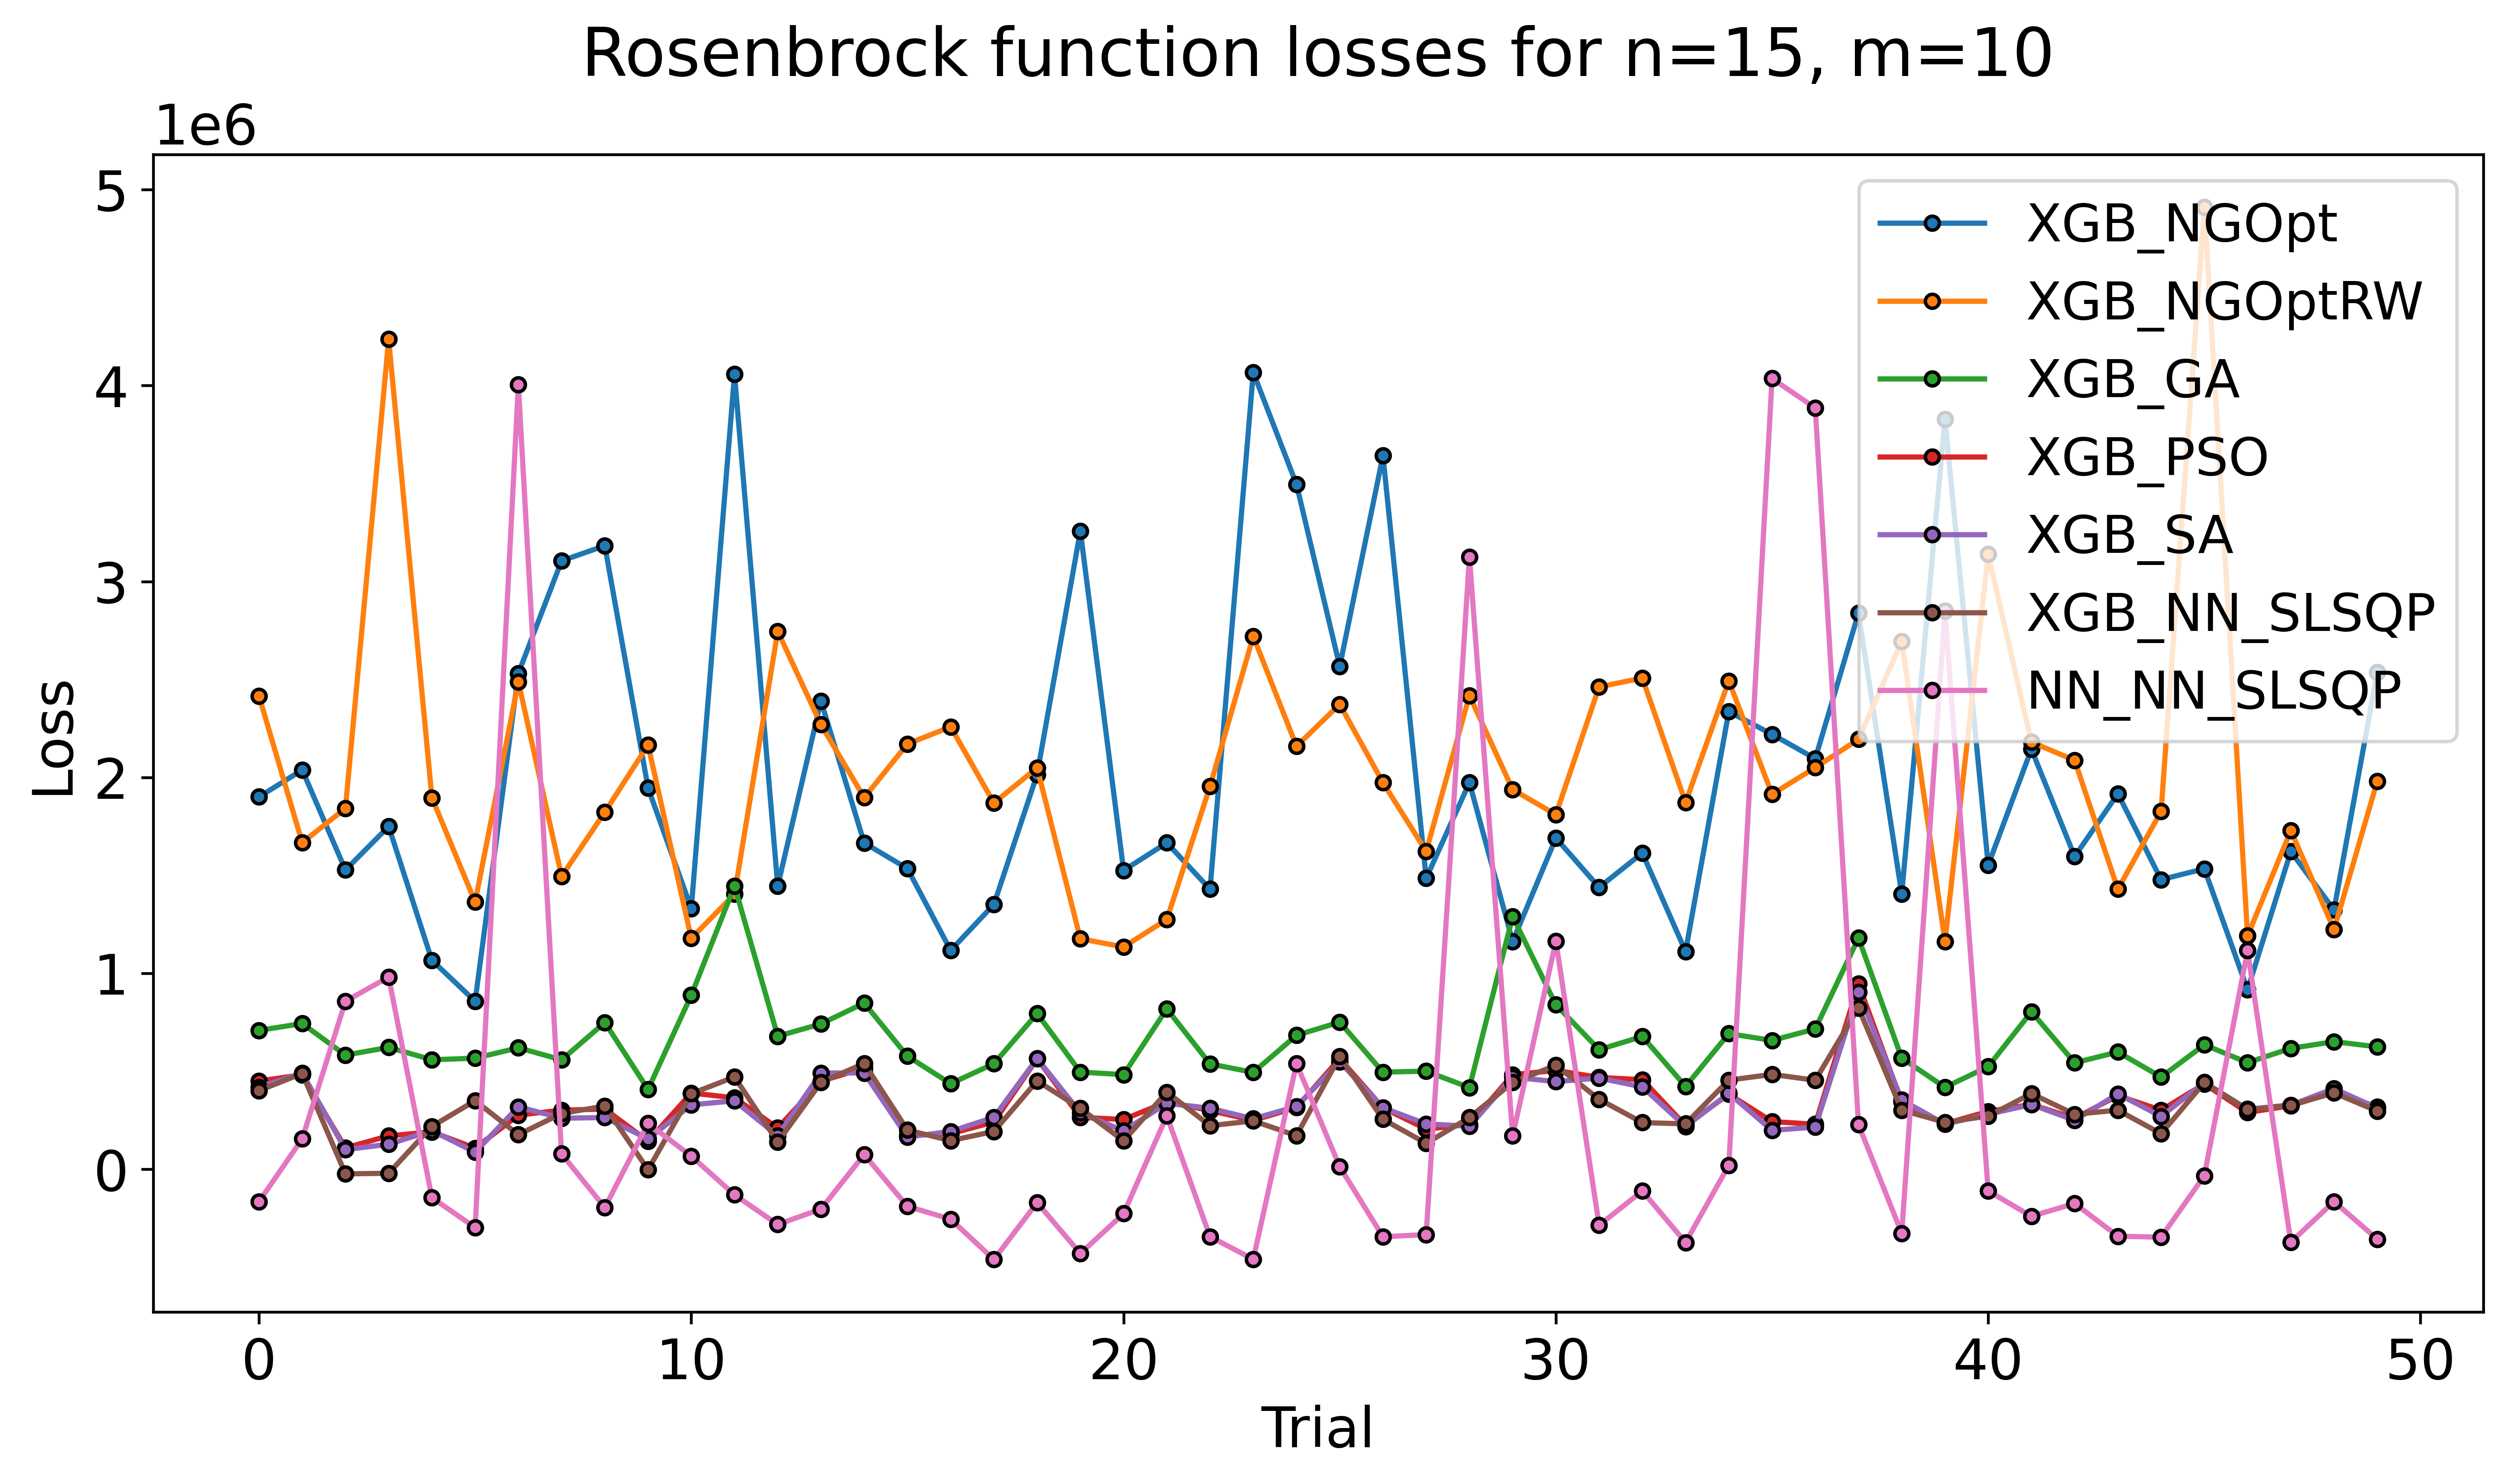

In [188]:
colors = [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#8c564b",  # Brown
    "#e377c2"   # Pink
]

def line_scatter_plot(losses_dict, methods):
    _,ax = plt.subplots(1,1)
    for color, method in zip(colors, methods):
        ax.plot(losses_dict[method],  markerfacecolor=color, label=method)
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0.)
    ax.legend(loc='best')
    ax.set_title(f"Rosenbrock function losses for n={n}, m={m}", y=1.05)
    ax.set_xlabel("Trial")
    ax.set_ylabel("Loss")

line_scatter_plot(losses_dict, methods)  


#tikzplotlib.save(f"fig_tex/rosenbrock_{n}_{m}_losses.tex")

In [189]:
def box_plot(losses_dict, methods, colors, title, ylabel):
    _, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Find method with minimum mean
    means = {method: np.abs(np.mean(losses_dict[method])) for method in methods}
    min_method_idx = list(methods).index(min(means, key=means.get))
    
    # Add gray column for minimum method
    ax.axvline(x=min_method_idx + 0.5, color='gray', linestyle='--', alpha=0.5, zorder=0)
    ax.axvline(x=min_method_idx + 1.5, color='gray', linestyle='--', alpha=0.5, zorder=0)
    ax.axvspan(min_method_idx + 0.5, min_method_idx + 1.5, 
               color='gray', alpha=0.2, zorder=0)
    
    data = [losses_dict[method] for method in methods]
    bp = ax.boxplot(data, patch_artist=True)
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
        
    for element in ['whiskers', 'caps', 'medians']:
        plt.setp(bp[element], color='black')
    
    ax.set_xticklabels(methods, rotation=45, fontsize=10, fontweight='bold')
    ax.set_title(f"Rosenbrock function {title} for n={n}, m={m}", y=1.05)
    ax.set_xlabel("Methods")
    ax.set_ylabel(ylabel)
    
    plt.tight_layout()
    return ax

<Axes: title={'center': 'Rosenbrock function distribtuion of losses for n=15, m=10'}, xlabel='Methods', ylabel='Loss'>

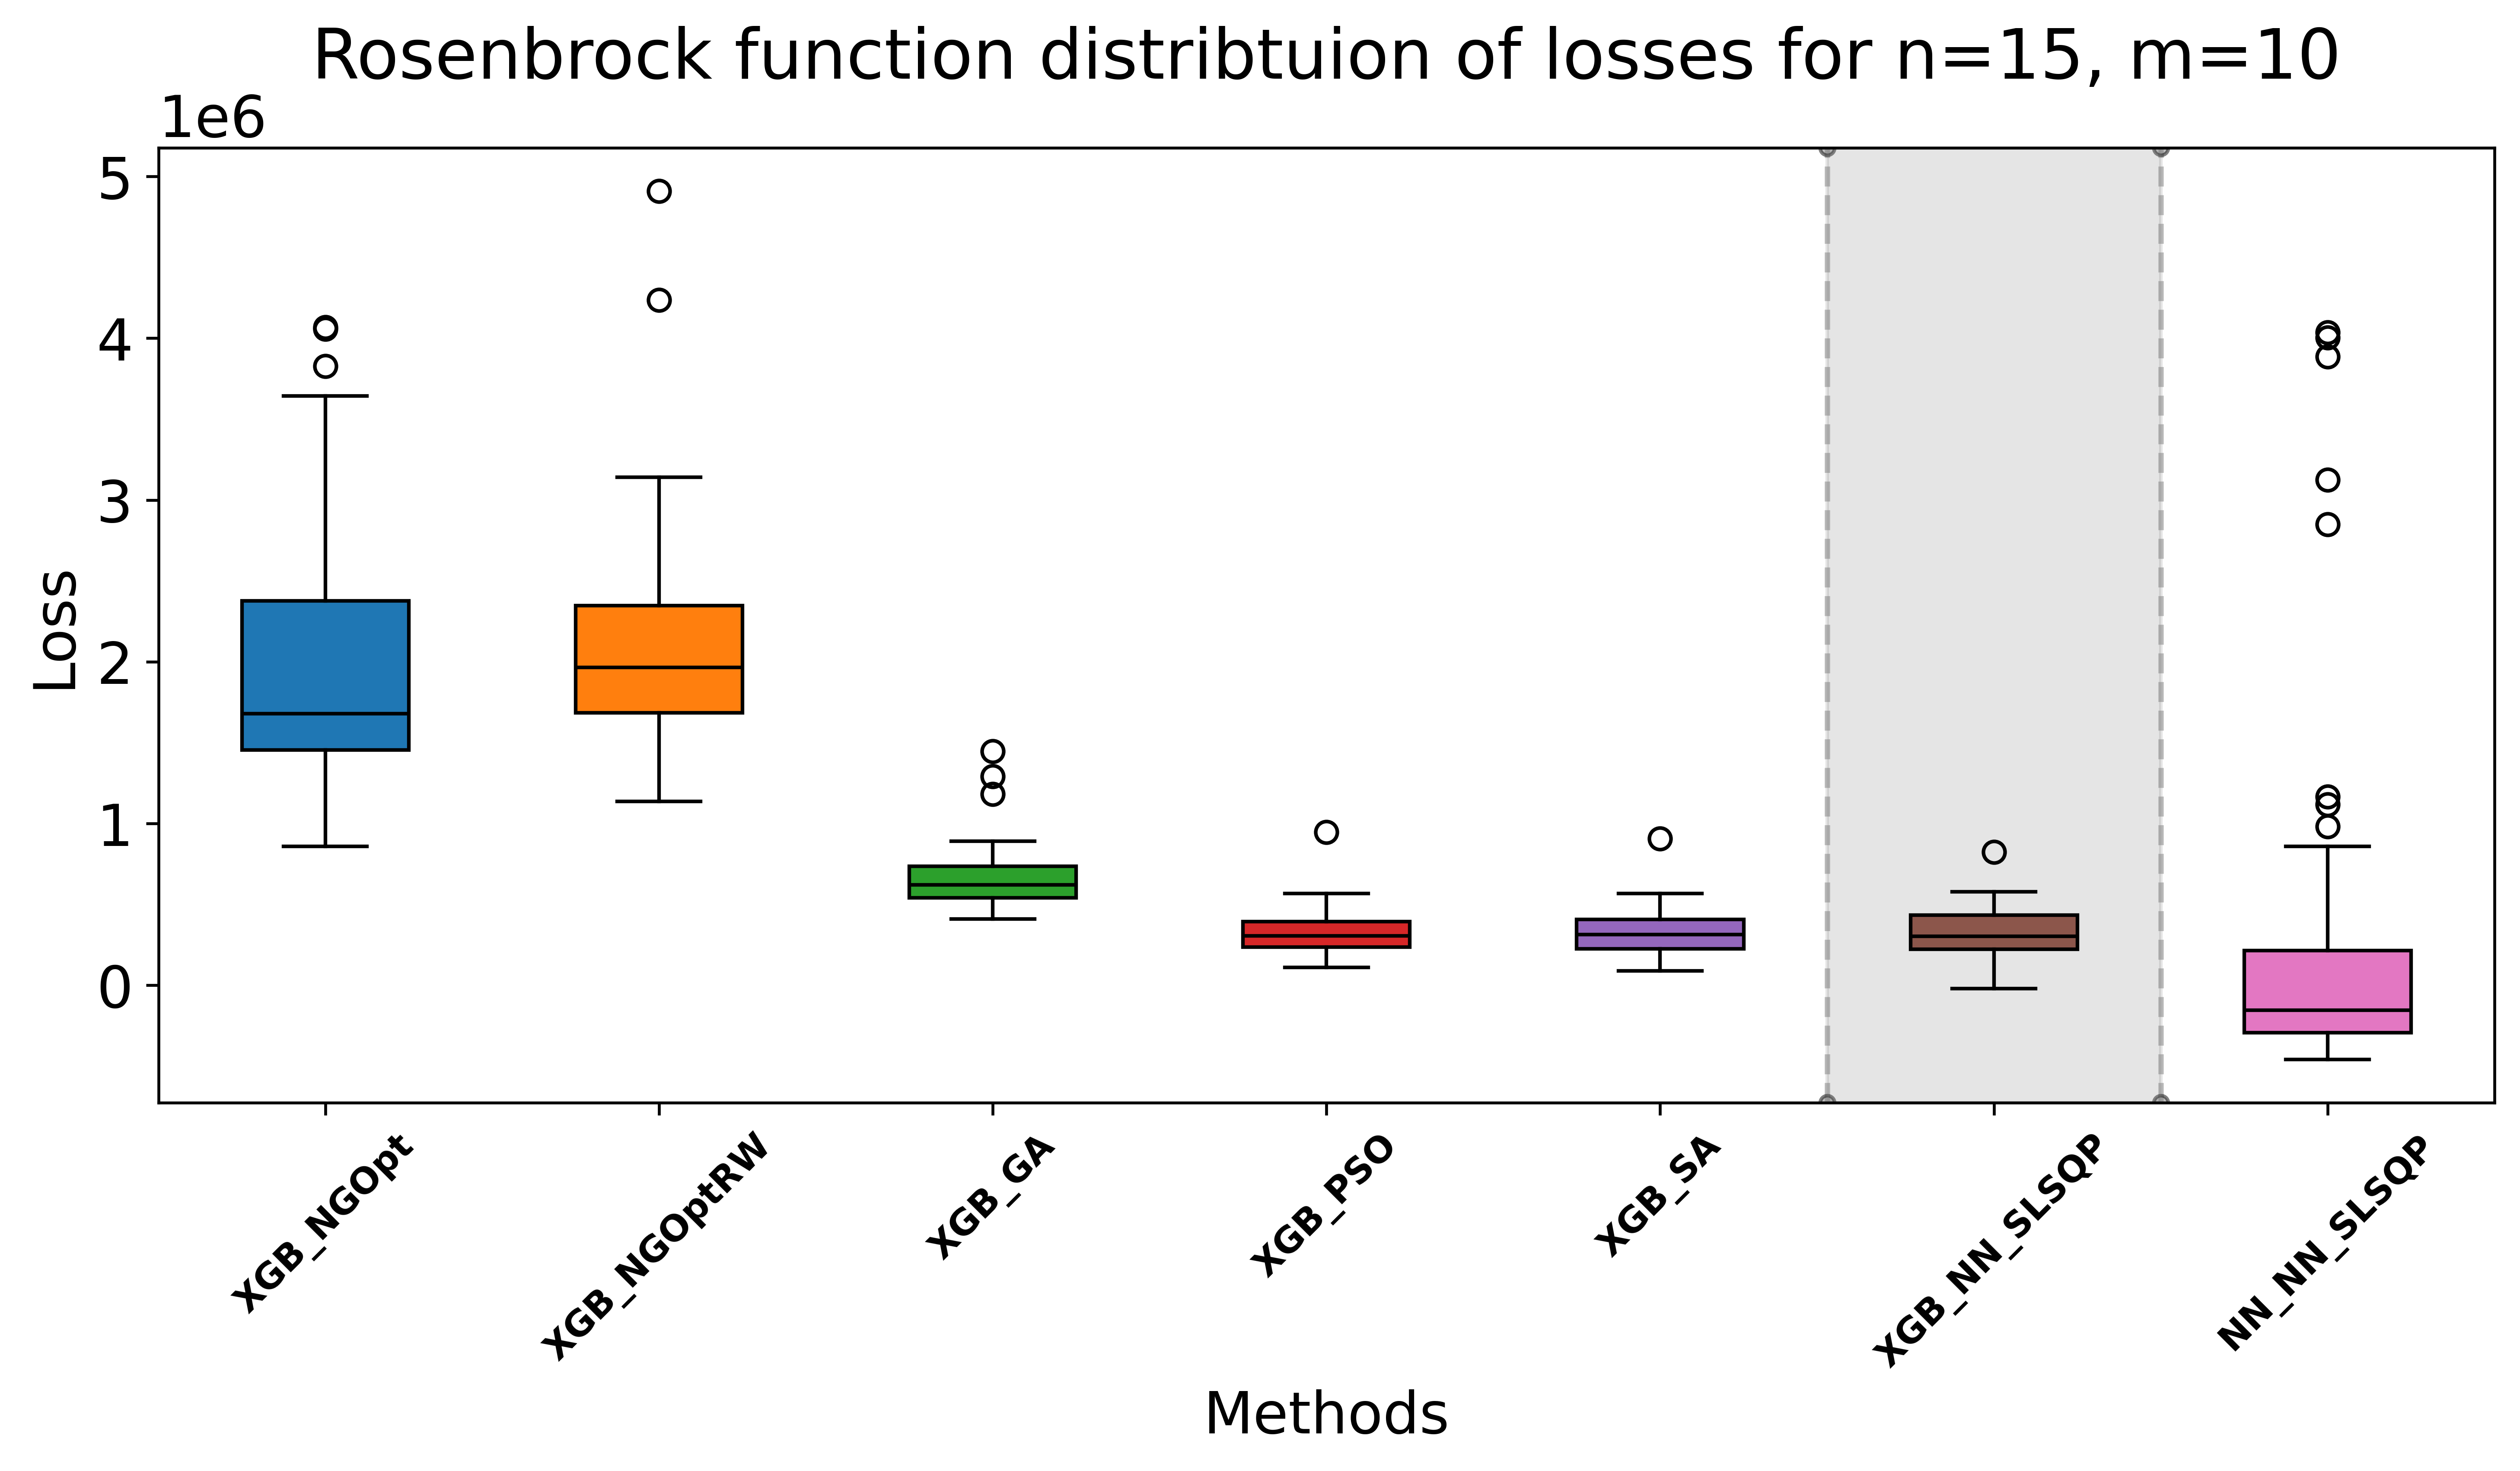

In [190]:
# Usage:
box_plot(losses_dict, methods, colors, "distribtuion of losses",  "Loss")

<Axes: title={'center': 'Rosenbrock function processing time for n=15, m=10'}, xlabel='Methods', ylabel='Time'>

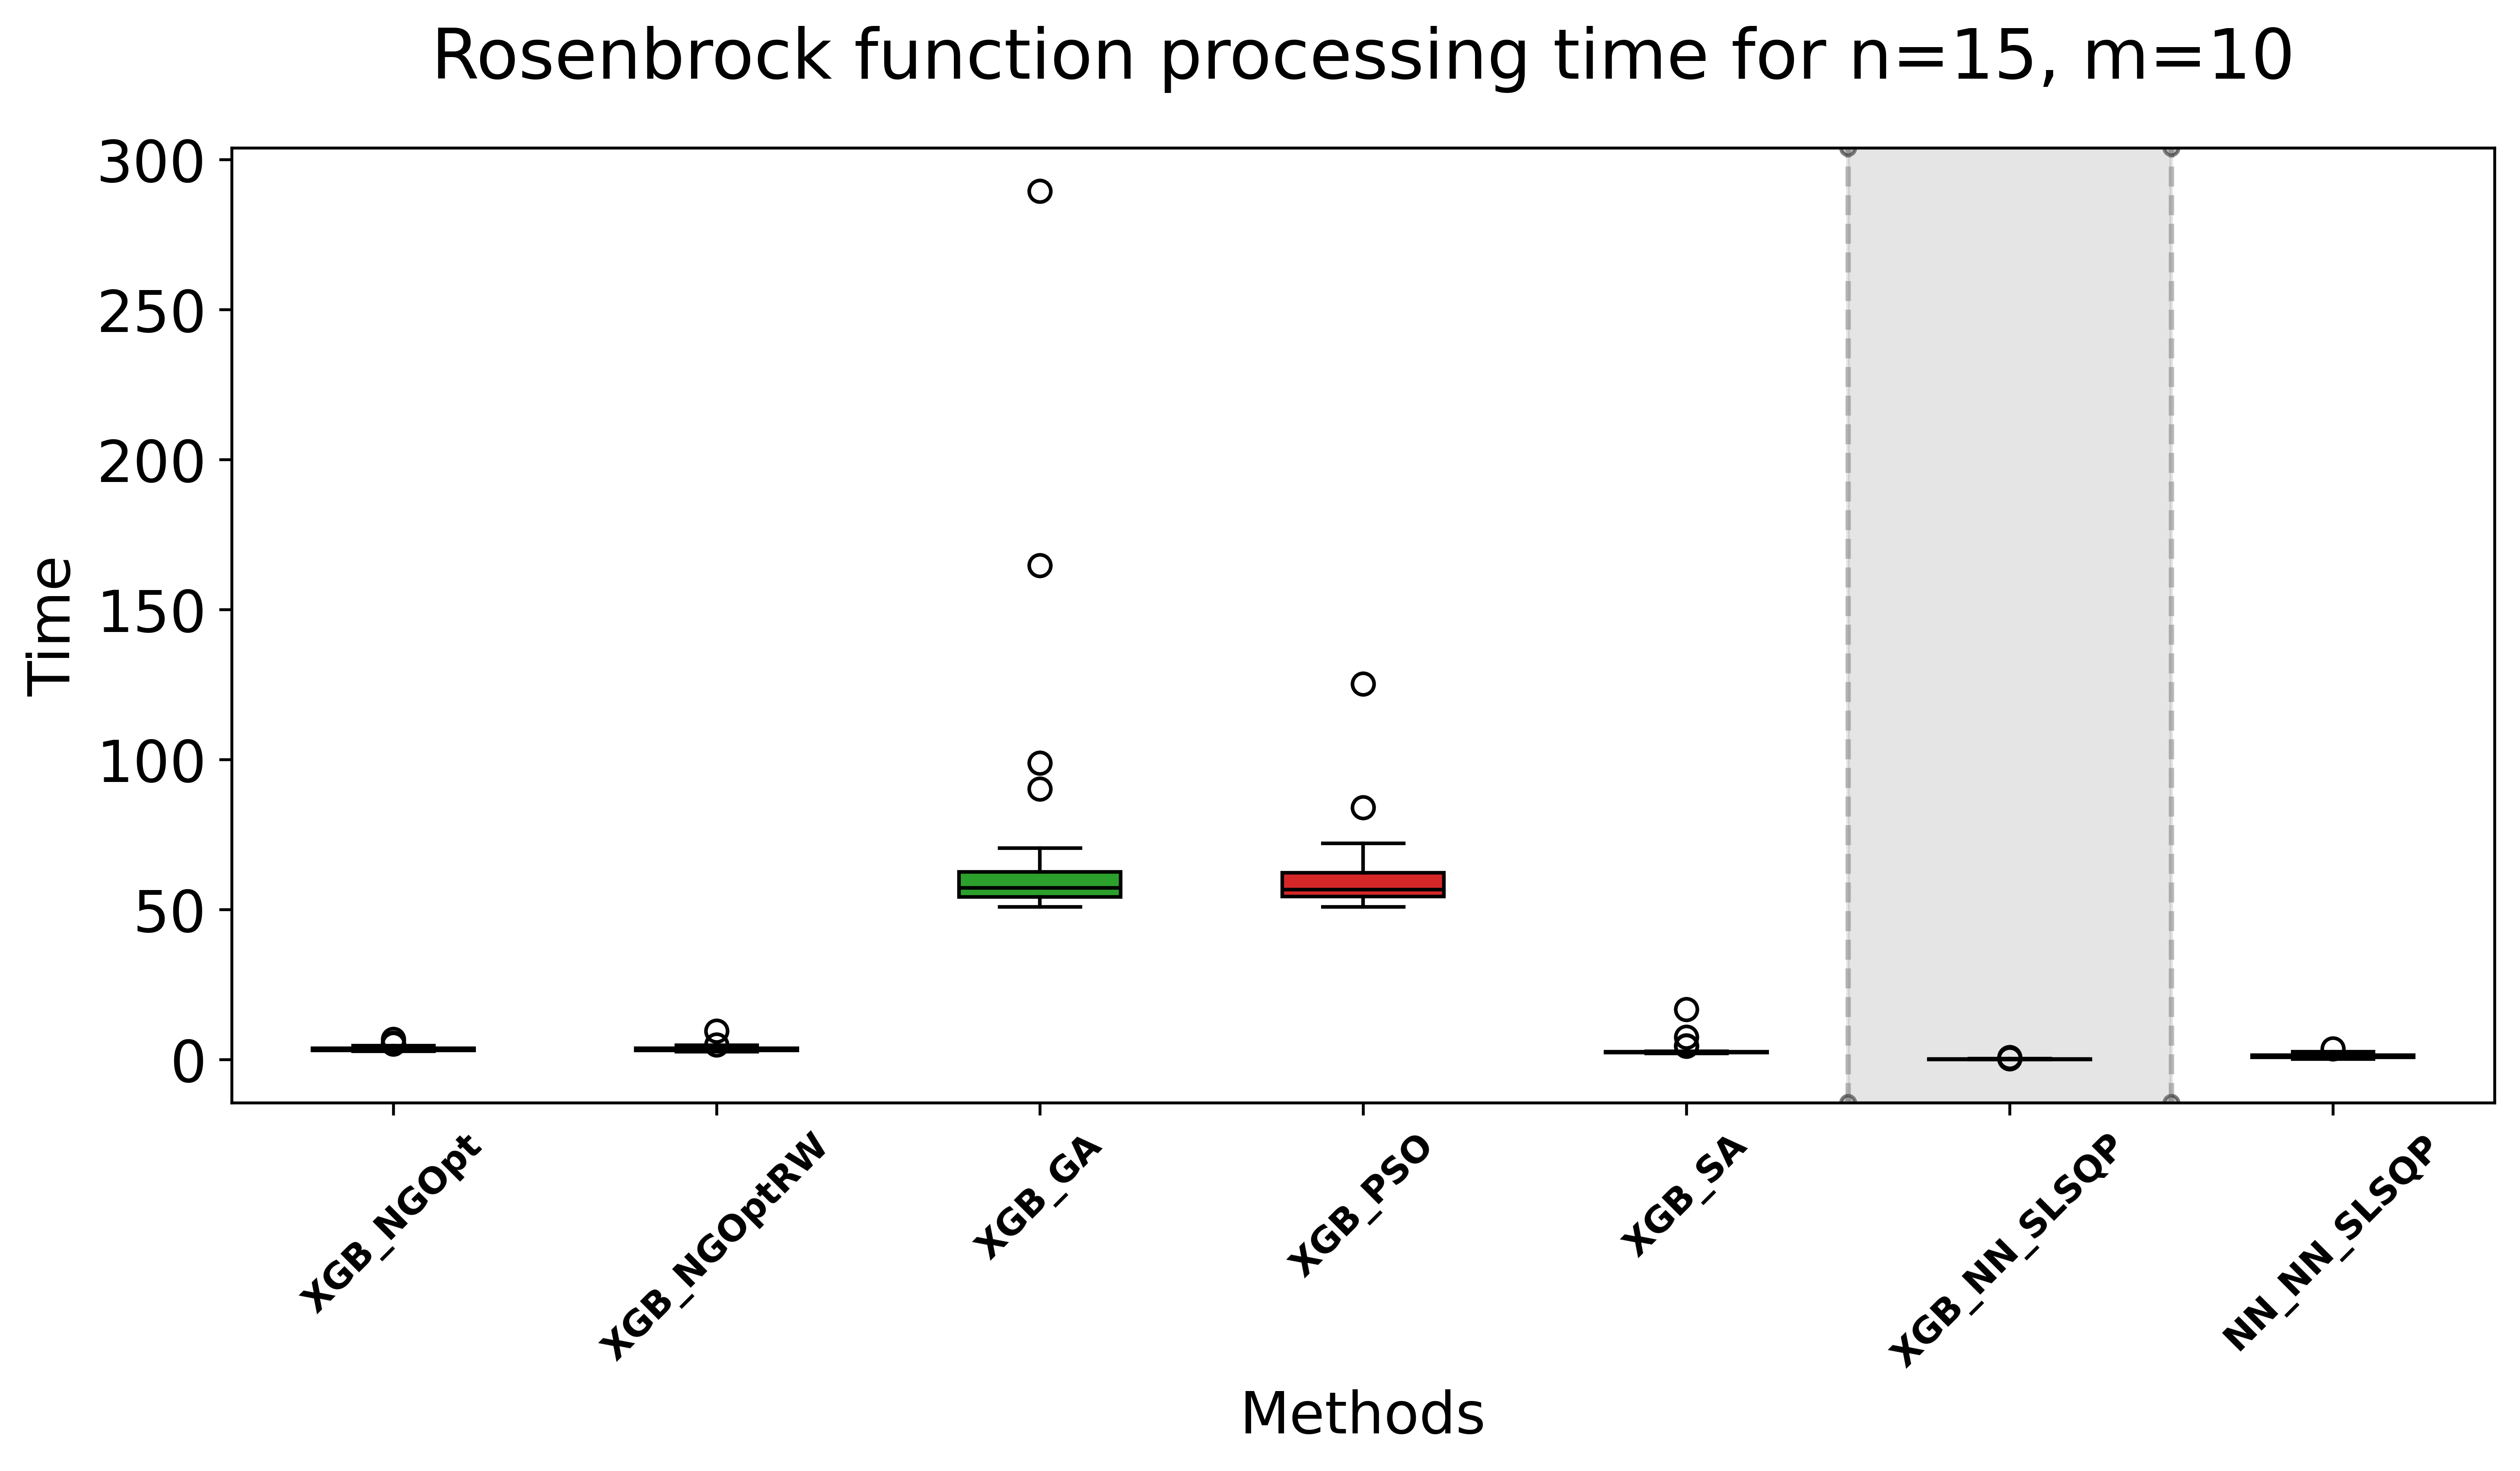

In [191]:
#time
# remove the time greater than 500
times_dict = {method: [time for time in times_dict[method] if time<500] for method in methods}
box_plot(times_dict, methods,colors, "processing time", "Time")

<Axes: title={'center': 'Rosenbrock function deviations from constraint for n=15, m=10'}, xlabel='Methods', ylabel='Deviation'>

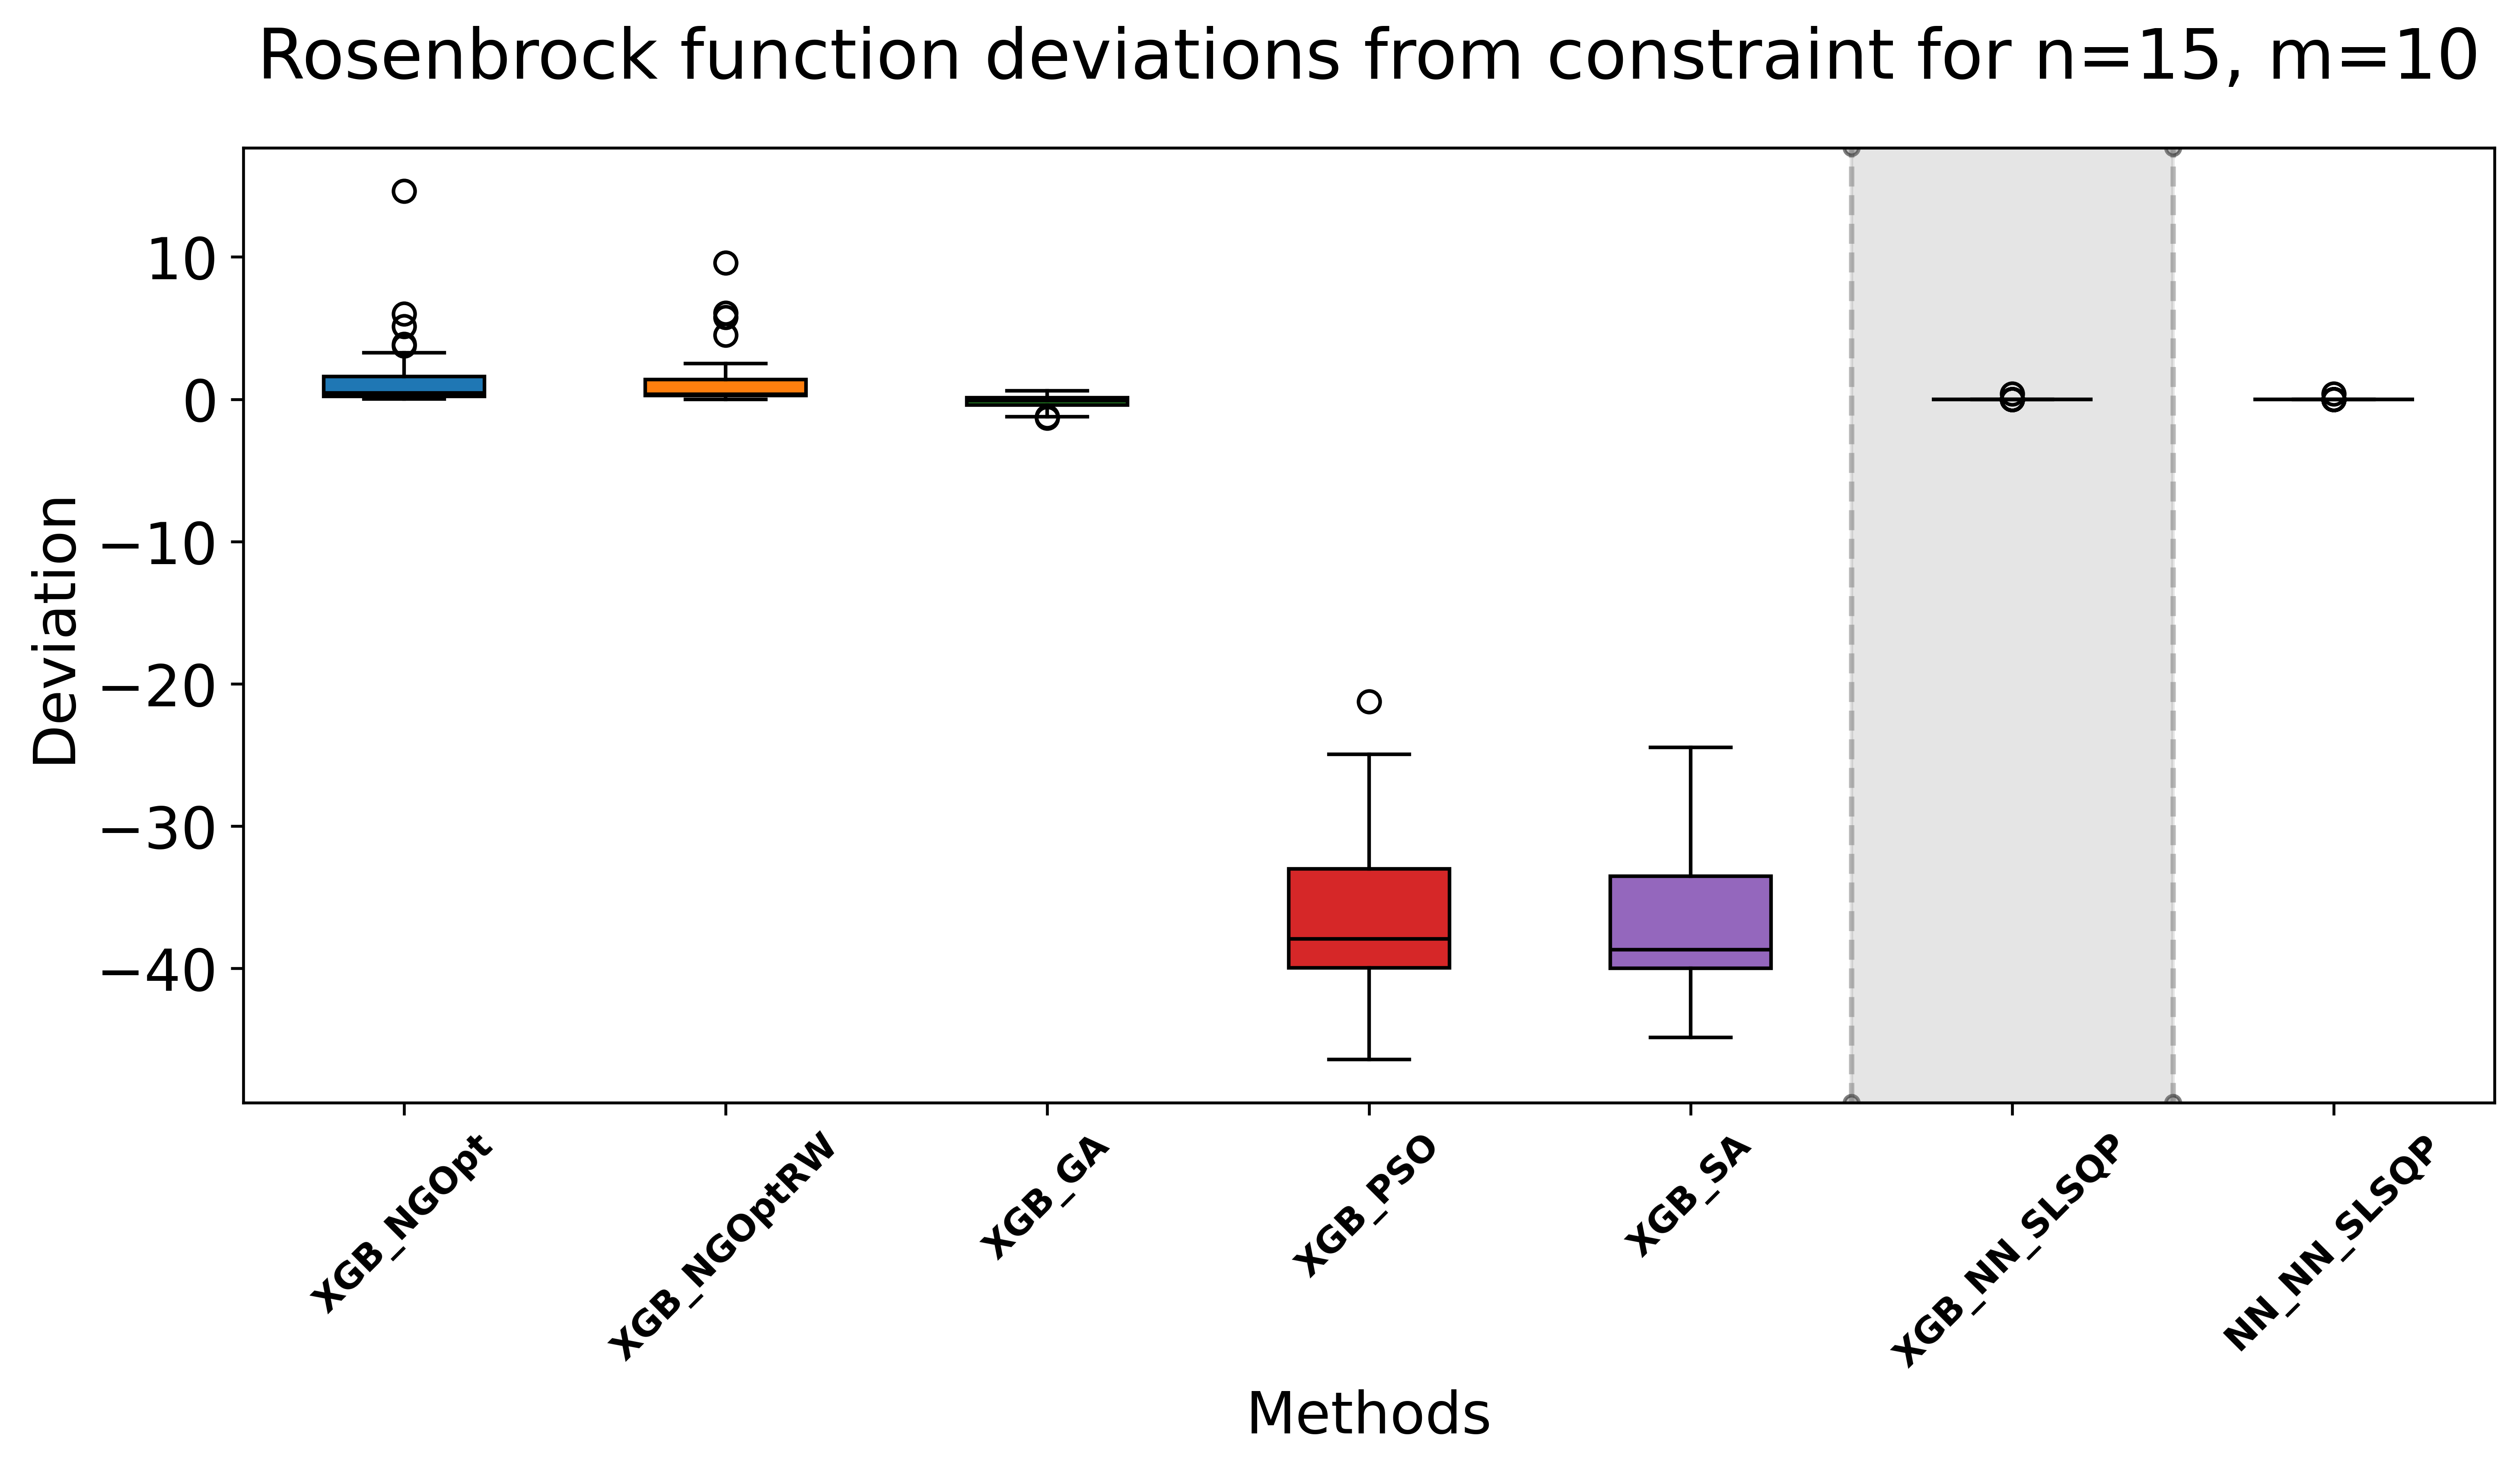

In [198]:
#deviation 
box_plot(deviations_dict, methods, colors, "deviations from constraint", "Deviation")

## Statistical evaluation

In [ ]:
print("Two-sided t-test for equality of means between SLSQP and...")
for method in methods:
    print(f"{method}: {stats.ttest_rel(losses_dict['XGB_NN_SLSQP'], losses_dict[method]).pvalue}")

Two-sided t-test for equality of means between SLSQP and...
XGB_NGOpt: 1.6430659880137766e-19
XGB_NGOptRW: 6.55406102915709e-22
XGB_GA: 4.5149708002021704e-20
XGB_PSO: 0.19275132678858947
XGB_SA: 0.5060843887982872
XGB_NN_SLSQP: nan
NN_NN_SLSQP: 0.9641613170008213


: 